In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import lstm
from scipy import stats
import copy
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
mice = ["mpfc14", "mpfc19", "mpfc20", "mpfc23", "mpfc24", "mpfc30"]
days = ["yd1", "yd2", "yd6"]

In [4]:
with open("h_spike_Wlim001.pkl", "rb") as f:
    h = pickle.load(f)

In [10]:
beh = []
for mi, mouse in enumerate(mice):
    behs = []
    for di, day in enumerate(days):
        df = pd.read_csv("behavior/" + mouse + "/" +mouse + "_" + day + ".csv", header=None).values
        
        n = np.sum(~np.isnan(df).any(axis=1))
        df = df[:n]
        t = np.zeros(n)
        for i in range(1, n-1):
            if df[i, 0] == 1:
                t[i] = 1
            else:
                if df[i-1, 0] == 1 and df[i+1, 0] == 1:
                    t[i] = 1
        df[:, 0] = t.copy()
        
        # remove "just-in-case" lick
        count = 0
        for i in range(n):
            if df[i, 2] == 1:
                count = 0
            elif df[i, 1] == 1:
                if count < 50:
                    df[i, 1] = 0
                count = 0
            else:
                count += 1

        behs.append(df)
    beh.append(behs)

In [12]:
with open("params.pkl", "rb") as f:
    params = pickle.load(f)
with open("n_beh.pkl", "rb") as f:
    n_beh = pickle.load(f)

In [13]:
preds = []
for mi, mouse in enumerate(mice):
    preds_s = []
    for di, day in enumerate(days):
        print(mouse, day)
        model = lstm.Decoder(params[mi][di])
        preds_s.append(model.predict(h[mi][di])[49:])
    preds.append(preds_s)

mpfc14 yd1
mpfc14 yd2
mpfc14 yd6
mpfc19 yd1
mpfc19 yd2
mpfc19 yd6
mpfc20 yd1
mpfc20 yd2
mpfc20 yd6
mpfc23 yd1
mpfc23 yd2
mpfc23 yd6
mpfc24 yd1
mpfc24 yd2
mpfc24 yd6
mpfc30 yd1
mpfc30 yd2
mpfc30 yd6


In [14]:
score = np.zeros((6, 3, 2, 8))
for mi, mouse in enumerate(mice):
    for di, dayi in enumerate(days):
        n = np.sum(~np.isnan(beh[mi][di]).any(axis=1))
        start, end = n_beh[mi][di]
        beh_train = beh[mi][di][start:end]
        beh_test = np.vstack((beh[mi][di][:start], beh[mi][di][end:n]))
        pred_train = preds[mi][di][start:end]
        pred_test = np.vstack((preds[mi][di][:start], preds[mi][di][end:n]))
        rate_train = [
            (len(beh_train[:, 0]) - beh_train[:, 0].sum()) / beh_train[:, 0].sum(),
            (len(beh_train[:, 1]) - beh_train[:, 1].sum()) / beh_train[:, 1].sum(),
            (beh_train[:, 1].sum() - beh_train[:, 2].sum()) / beh_train[:, 2].sum()
        ]
        rate_test = [
            (len(beh_test[:, 0]) - beh_test[:, 0].sum()) / beh_test[:, 0].sum(),
            (len(beh_test[:, 1]) - beh_test[:, 1].sum()) / beh_test[:, 1].sum(),
            (beh_test[:, 1].sum() - beh_test[:, 2].sum()) / beh_test[:, 2].sum()
        ]
        err_train = np.square(pred_train - beh_train)
        err_test = np.square(pred_test - beh_test)
        num_train = np.ones_like(err_train)
        num_test = np.ones_like(err_test)
        
        err_train[beh_train[:, 0] == 1, 0] *= rate_train[0]
        num_train[beh_train[:, 0] == 1, 0] *= rate_train[0]
        err_train[beh_train[:, 1] == 1, 1] *= rate_train[1]
        num_train[beh_train[:, 1] == 1, 1] *= rate_train[1]
        err_train[beh_train[:, 2] == 1, 2] *= rate_train[2]
        num_train[beh_train[:, 2] == 1, 2] *= rate_train[2]
        err_train[beh_train[:, 1] == 0, 2] *= 0
        num_train[beh_train[:, 1] == 0, 2] *= 0
        
        err_test[beh_test[:, 0] == 1, 0] *= rate_test[0]
        num_test[beh_test[:, 0] == 1, 0] *= rate_test[0]
        err_test[beh_test[:, 1] == 1, 1] *= rate_test[1]
        num_test[beh_test[:, 1] == 1, 1] *= rate_test[1]
        err_test[beh_test[:, 2] == 1, 2] *= rate_test[2]
        num_test[beh_test[:, 2] == 1, 2] *= rate_test[2]
        err_test[beh_test[:, 1] == 0, 2] *= 0
        num_test[beh_test[:, 1] == 0, 2] *= 0
        
        score[mi, di, 0, :5] = err_train.sum(axis=0) / num_train.sum(axis=0)
        score[mi, di, 1, :5] = err_test.sum(axis=0) / num_test.sum(axis=0)
        score[mi, di, 0, 5] = pred_train[beh_train[:, 2] == 1, 2].mean() / pred_train[(beh_train[:, 1] == 1) & (beh_train[:, 2] == 0), 2].mean()
        score[mi, di, 1, 5] = pred_test[beh_test[:, 2] == 1, 2].mean() / pred_test[(beh_test[:, 1] == 1) & (beh_test[:, 2] == 0), 2].mean()
        score[mi, di, 0, 6:] = score[mi, di, 0, 3:5] / np.square(beh_train[:, 3:] - beh_train[:, 3:].mean(axis=0)).mean(axis=0)
        score[mi, di, 1, 6:] = score[mi, di, 1, 3:5] / np.square(beh_test[:, 3:] - beh_test[:, 3:].mean(axis=0)).mean(axis=0)

0 0
Ttest_relResult(statistic=2.7729676701210972, pvalue=0.03922721320792262)
Ttest_relResult(statistic=1.267407491228364, pvalue=0.2608288843527579)
Ttest_relResult(statistic=-2.3864000033861688, pvalue=0.06266631664147863)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  4.5147 2.0000 10.0000 0.0401

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0415 0.1708 -0.0979   0.015  False
     0      2  -0.0732 0.0111 -0.1296 -0.0167   True
     1      2  -0.0317 0.3384 -0.0881  0.0248  False
----------------------------------------------------
(array([0. , 0.1, 0.2, 0.3, 0.4]), <a list of 0 Text yticklabel objects>)


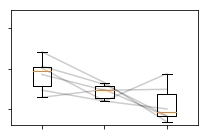

0 1
Ttest_relResult(statistic=2.1577962032369418, pvalue=0.08341893822897513)
Ttest_relResult(statistic=2.432591230642892, pvalue=0.05919136250529395)
Ttest_relResult(statistic=-2.726017525593499, pvalue=0.041476499358686345)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  6.6085 2.0000 10.0000 0.0148

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0351 0.2417 -0.0891  0.0189  False
     0      2  -0.0861 0.0024   -0.14 -0.0321   True
     1      2   -0.051 0.0656 -0.1049   0.003  False
----------------------------------------------------
(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]), <a list of 0 Text yticklabel objects>)


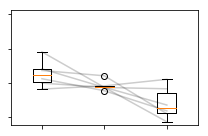

1 0
Ttest_relResult(statistic=-1.1898441096211458, pvalue=0.2875201514867003)
Ttest_relResult(statistic=3.380427954269668, pvalue=0.01966502336989933)
Ttest_relResult(statistic=-0.30552648645010455, pvalue=0.7722758205217783)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  2.1029 2.0000 10.0000 0.1728

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0237 0.3013 -0.0163 0.0638  False
     0      2  -0.0041    0.9 -0.0441 0.0359  False
     1      2  -0.0278 0.2016 -0.0678 0.0122  False
---------------------------------------------------
(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]), <a list of 0 Text yticklabel objects>)


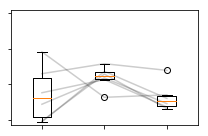

1 1
Ttest_relResult(statistic=-0.49904600037763813, pvalue=0.6389247104230679)
Ttest_relResult(statistic=0.07866567428645187, pvalue=0.9403497758487376)
Ttest_relResult(statistic=0.6085605556023899, pvalue=0.5693997706395666)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  0.2584 2.0000 10.0000 0.7773

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1    0.009 0.8552 -0.0358 0.0537  False
     0      2   0.0083 0.8767 -0.0365 0.0531  False
     1      2  -0.0007    0.9 -0.0454 0.0441  False
---------------------------------------------------
(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]), <a list of 0 Text yticklabel objects>)


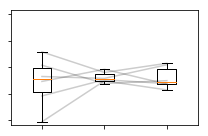

2 0
Ttest_relResult(statistic=4.411153772752552, pvalue=0.006949084863430483)
Ttest_relResult(statistic=1.283632765086144, pvalue=0.25553799518490594)
Ttest_relResult(statistic=-6.740880195440098, pvalue=0.0010899523052947655)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day 19.0057 2.0000 10.0000 0.0004

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.1713  0.001 -0.2686  -0.074   True
     0      2  -0.2247  0.001  -0.322 -0.1274   True
     1      2  -0.0534 0.3538 -0.1507  0.0439  False
----------------------------------------------------
(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8]), <a list of 0 Text yticklabel objects>)


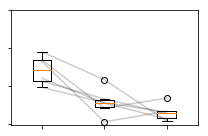

2 1
Ttest_relResult(statistic=1.5013596177961834, pvalue=0.19356537385706152)
Ttest_relResult(statistic=2.5056358979086055, pvalue=0.054115860539651756)
Ttest_relResult(statistic=-11.803040406801871, pvalue=7.682461436304397e-05)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day 10.5171 2.0000 10.0000 0.0035

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0819 0.1429 -0.1875 0.0237  False
     0      2  -0.1856  0.001 -0.2912  -0.08   True
     1      2  -0.1037 0.0546 -0.2093 0.0019  False
---------------------------------------------------
(array([0. , 0.2, 0.4, 0.6]), <a list of 0 Text yticklabel objects>)


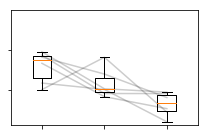

3 0
Ttest_relResult(statistic=3.6759076802461803, pvalue=0.01435467800125066)
Ttest_relResult(statistic=-0.15681007803357158, pvalue=0.8815297405778622)
Ttest_relResult(statistic=-1.5730158864874864, pvalue=0.17652450183182888)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  2.7632 2.0000 10.0000 0.1108

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0096  0.095 -0.0206 0.0015  False
     0      2  -0.0088 0.1297 -0.0198 0.0022  False
     1      2   0.0008    0.9 -0.0103 0.0118  False
---------------------------------------------------
(array([0.02, 0.04, 0.06, 0.08]), <a list of 0 Text yticklabel objects>)


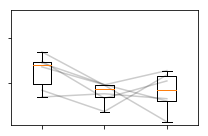

3 1
Ttest_relResult(statistic=5.844737062522603, pvalue=0.0020752941493432384)
Ttest_relResult(statistic=-1.095822917010449, pvalue=0.32310978049934164)
Ttest_relResult(statistic=-0.7751487550661046, pvalue=0.4732986610559905)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  2.3957 2.0000 10.0000 0.1412

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0107 0.1081 -0.0235 0.0021  False
     0      2   -0.005  0.579 -0.0178 0.0078  False
     1      2   0.0057 0.4921 -0.0071 0.0185  False
---------------------------------------------------
(array([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]), <a list of 0 Text yticklabel objects>)


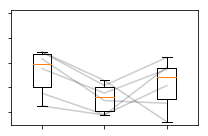

4 0
Ttest_relResult(statistic=-0.8149169047044669, pvalue=0.4521734850592832)
Ttest_relResult(statistic=-0.5133048924927534, pvalue=0.6296063806774517)
Ttest_relResult(statistic=1.1454641186120986, pvalue=0.30386624931895767)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  0.7548 2.0000 10.0000 0.4951

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0016 0.7992  -0.005 0.0082  False
     0      2   0.0029 0.5099 -0.0037 0.0095  False
     1      2   0.0013 0.8582 -0.0053 0.0079  False
---------------------------------------------------
(array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035]), <a list of 0 Text yticklabel objects>)


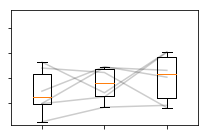

4 1
Ttest_relResult(statistic=-1.366979873606538, pvalue=0.22988537666243192)
Ttest_relResult(statistic=-1.3623304267094907, pvalue=0.23125080702694867)
Ttest_relResult(statistic=2.146058601372007, pvalue=0.08466595333179963)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  3.0209 2.0000 10.0000 0.0941

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0023 0.6649 -0.0047 0.0093  False
     0      2   0.0068 0.0587 -0.0002 0.0138  False
     1      2   0.0045 0.2549 -0.0025 0.0114  False
---------------------------------------------------
(array([0.01, 0.02, 0.03, 0.04, 0.05]), <a list of 0 Text yticklabel objects>)


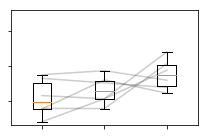

5 0
Ttest_relResult(statistic=-1.1630667154945553, pvalue=0.29728718854972536)
Ttest_relResult(statistic=-0.1202763847609812, pvalue=0.9089478465897942)
Ttest_relResult(statistic=3.5525874091212137, pvalue=0.016342564509020822)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  1.1988 2.0000 10.0000 0.3414

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   4.5156 0.3801 -4.0238 13.0551  False
     0      2   5.0752    0.3 -3.4642 13.6146  False
     1      2   0.5595    0.9 -7.9799  9.0989  False
----------------------------------------------------
(array([ 0., 10., 20., 30., 40.]), <a list of 0 Text yticklabel objects>)


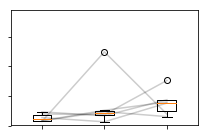

5 1
Ttest_relResult(statistic=-0.8244615589661882, pvalue=0.4472092712634791)
Ttest_relResult(statistic=-0.5990789804523892, pvalue=0.5752280706856833)
Ttest_relResult(statistic=2.384326088862058, pvalue=0.0628274320227975)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  1.2848 2.0000 10.0000 0.3187

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   1.1513 0.5874 -1.8511 4.1537  False
     0      2   2.0425 0.2142 -0.9599 5.0449  False
     1      2   0.8912 0.7139 -2.1112 3.8936  False
---------------------------------------------------
(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5]), <a list of 0 Text yticklabel objects>)


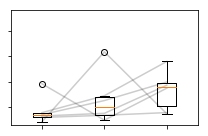

6 0
Ttest_relResult(statistic=5.390700027565219, pvalue=0.0029645064240192546)
Ttest_relResult(statistic=0.7065723702534716, pvalue=0.5113889756625092)
Ttest_relResult(statistic=-2.3352711566022943, pvalue=0.06677180101185702)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  4.8812 2.0000 10.0000 0.0332

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.1981  0.054 -0.3994  0.0032  False
     0      2  -0.2657 0.0098  -0.467 -0.0644   True
     1      2  -0.0676 0.6573 -0.2689  0.1337  False
----------------------------------------------------
(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 ]), <a list of 0 Text yticklabel objects>)


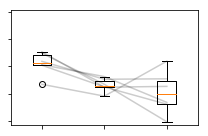

6 1
Ttest_relResult(statistic=4.247323392803882, pvalue=0.008112546058762476)
Ttest_relResult(statistic=0.26179152071592554, pvalue=0.8039246190860508)
Ttest_relResult(statistic=-2.148588679496939, pvalue=0.08439549371292858)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  4.8915 2.0000 10.0000 0.0330

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.2091 0.0382 -0.4073 -0.0108   True
     0      2  -0.2293 0.0228 -0.4275  -0.031   True
     1      2  -0.0202    0.9 -0.2185  0.1781  False
----------------------------------------------------
(array([0.4, 0.6, 0.8, 1. , 1.2, 1.4]), <a list of 0 Text yticklabel objects>)


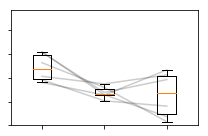

7 0
Ttest_relResult(statistic=1.8540867256561147, pvalue=0.12290134858062324)
Ttest_relResult(statistic=3.623043152653343, pvalue=0.015170952300879675)
Ttest_relResult(statistic=-2.981084914116461, pvalue=0.030761453497686032)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  9.0009 2.0000 10.0000 0.0058

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0814 0.4049 -0.2408  0.0781  False
     0      2  -0.2741 0.0012 -0.4335 -0.1147   True
     1      2  -0.1927 0.0174 -0.3522 -0.0333   True
----------------------------------------------------
(array([0.4, 0.6, 0.8, 1. , 1.2, 1.4]), <a list of 0 Text yticklabel objects>)


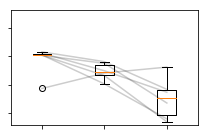

7 1
Ttest_relResult(statistic=1.7468353766620615, pvalue=0.14109658363773206)
Ttest_relResult(statistic=3.4389631160252168, pvalue=0.018456017804948485)
Ttest_relResult(statistic=-2.671213337791392, pvalue=0.04428402670926888)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  6.7411 2.0000 10.0000 0.0140

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0767  0.265  -0.199  0.0456  False
     0      2  -0.1865 0.0034 -0.3088 -0.0642   True
     1      2  -0.1098 0.0818 -0.2321  0.0125  False
----------------------------------------------------
(array([0.6, 0.8, 1. , 1.2, 1.4]), <a list of 0 Text yticklabel objects>)


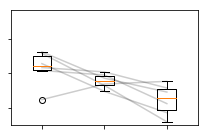

In [53]:
for si in range(8):
    for ti in range(2):
        print(si, ti)
        plt.figure(figsize=(3, 2))
        for s in score[:, :, ti, si]:
            plt.plot(np.arange(1, 4), s, color="k", alpha=0.2)
        plt.boxplot(score[:, :, ti, si])
        for i in range(3):
            print(stats.ttest_rel(score[:, i, ti, si], score[:, (i+1) % 3, ti, si]))
        df = pd.DataFrame({
            "mouse": np.tile(np.arange(6), 3),
            "day": np.repeat(np.arange(3), 6),
            "error": np.hstack([score[:, i, ti, si] for i in range(3)])
        })
        print(AnovaRM(data=df, depvar="error", subject="mouse", within=["day"]).fit())
        tukey = pairwise_tukeyhsd(endog=df['error'],
                                  groups=df['day'],
                                  alpha=0.05)
        print(tukey)
        plt.xticks([1, 2, 3], ["Day 1", "Day 2", "Day6"])
        plt.tick_params(labelleft=False, labelbottom=False)
        y0, y1 = plt.ylim()
        plt.ylim(y0, y1 + (y1 - y0) / 2)
        plt.tight_layout()
        print(plt.yticks())
        plt.savefig("decoder/" + str(si) + "_" + str(ti) + ".png")
        plt.show()

In [16]:
score_full = np.zeros((6, 3, 8))
for mi, mouse in enumerate(mice):
    for di, dayi in enumerate(days):
        n = np.sum(~np.isnan(beh[mi][di]).any(axis=1))
        beh_full = beh[mi][di][:n]
        pred_full = preds[mi][di][:n]
        rate = [
            (len(beh_full[:, 0]) - beh_full[:, 0].sum()) / beh_full[:, 0].sum(),
            (len(beh_full[:, 1]) - beh_full[:, 1].sum()) / beh_full[:, 1].sum(),
            (beh_full[:, 1].sum() - beh_full[:, 2].sum()) / beh_full[:, 2].sum()
        ]
        err_full = np.square(pred_full - beh_full)
        num_full = np.ones_like(err_full)
        
        err_full[beh_full[:, 0] == 1, 0] *= rate[0]
        num_full[beh_full[:, 0] == 1, 0] *= rate[0]
        err_full[beh_full[:, 1] == 1, 1] *= rate[1]
        num_full[beh_full[:, 1] == 1, 1] *= rate[1]
        err_full[beh_full[:, 2] == 1, 2] *= rate[2]
        num_full[beh_full[:, 2] == 1, 2] *= rate[2]
        err_full[beh_full[:, 1] == 0, 2] *= 0
        num_full[beh_full[:, 1] == 0, 2] *= 0
        
        score_full[mi, di, :5] = err_full.sum(axis=0) / num_full.sum(axis=0)
        score_full[mi, di, 5] = pred_full[beh_full[:, 2] == 1, 2].mean() / pred_full[(beh_full[:, 1] == 1) & (beh_full[:, 2] == 0), 2].mean()
        score_full[mi, di, 6:] = score_full[mi, di, 3:5] / np.square(beh_full[:, 3:] - beh_full[:, 3:].mean(axis=0)).mean(axis=0)

0
Ttest_relResult(statistic=3.1086851362243637, pvalue=0.02659033795345682)
Ttest_relResult(statistic=2.195344974041629, pvalue=0.07955902040840557)
Ttest_relResult(statistic=-2.8445682704120365, pvalue=0.03605265585988828)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  7.3061 2.0000 10.0000 0.0111

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0396 0.1474 -0.0912  0.0119  False
     0      2  -0.0857 0.0017 -0.1373 -0.0342   True
     1      2  -0.0461 0.0833 -0.0977  0.0055  False
----------------------------------------------------
(array([0. , 0.1, 0.2, 0.3, 0.4]), <a list of 0 Text yticklabel objects>)


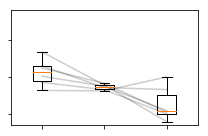

1
Ttest_relResult(statistic=-0.9257359400529321, pvalue=0.39706662902799816)
Ttest_relResult(statistic=1.9818262723898974, pvalue=0.10433423328088075)
Ttest_relResult(statistic=0.11165906207571343, pvalue=0.9154377012478144)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  0.9527 2.0000 10.0000 0.4181

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1    0.016 0.5392 -0.0225 0.0546  False
     0      2   0.0013    0.9 -0.0372 0.0399  False
     1      2  -0.0147 0.5899 -0.0532 0.0238  False
---------------------------------------------------
(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]), <a list of 0 Text yticklabel objects>)


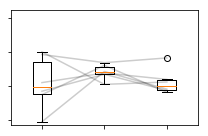

2
Ttest_relResult(statistic=2.6959122190858174, pvalue=0.0429936078613007)
Ttest_relResult(statistic=3.2994321300873732, pvalue=0.02148893737372667)
Ttest_relResult(statistic=-9.62653668337063, pvalue=0.0002051201616361022)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day 21.0372 2.0000 10.0000 0.0003

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.1151 0.0067 -0.1978 -0.0324   True
     0      2   -0.206  0.001 -0.2887 -0.1233   True
     1      2  -0.0909 0.0304 -0.1736 -0.0082   True
----------------------------------------------------
(array([0. , 0.2, 0.4, 0.6]), <a list of 0 Text yticklabel objects>)


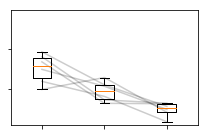

3
Ttest_relResult(statistic=5.586960304172626, pvalue=0.0025341073351880542)
Ttest_relResult(statistic=-0.6934903801591772, pvalue=0.5188917046025262)
Ttest_relResult(statistic=-1.198015756741402, pvalue=0.2845968748868271)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  2.7578 2.0000 10.0000 0.1112

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0101 0.0835 -0.0215 0.0012  False
     0      2  -0.0069 0.2857 -0.0182 0.0045  False
     1      2   0.0032 0.7292 -0.0081 0.0146  False
---------------------------------------------------
(array([0.03, 0.04, 0.05, 0.06, 0.07, 0.08]), <a list of 0 Text yticklabel objects>)


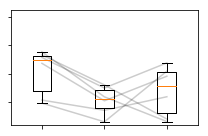

4
Ttest_relResult(statistic=-1.62669146196469, pvalue=0.16473116843283364)
Ttest_relResult(statistic=-1.2544812814690491, pvalue=0.2651153089535007)
Ttest_relResult(statistic=1.964670468160214, pvalue=0.10664866927017677)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  2.7766 2.0000 10.0000 0.1099

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0019 0.6408 -0.0037 0.0075  False
     0      2   0.0048 0.0971 -0.0008 0.0104  False
     1      2   0.0029 0.3993 -0.0027 0.0085  False
---------------------------------------------------
(array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ]), <a list of 0 Text yticklabel objects>)


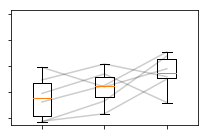

5
Ttest_relResult(statistic=-1.1320874595783919, pvalue=0.30895090667759)
Ttest_relResult(statistic=-0.17475971826932207, pvalue=0.8681246205914356)
Ttest_relResult(statistic=3.424703549097829, pvalue=0.01874257154734102)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  1.3062 2.0000 10.0000 0.3133

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   2.1434 0.3562 -1.7736 6.0603  False
     0      2    2.506 0.2519 -1.4109 6.4229  False
     1      2   0.3626    0.9 -3.5543 4.2796  False
---------------------------------------------------
(array([ 0.,  5., 10., 15., 20.]), <a list of 0 Text yticklabel objects>)


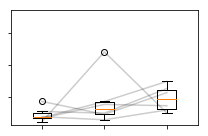

6
Ttest_relResult(statistic=4.921578547458794, pvalue=0.0043914940830296605)
Ttest_relResult(statistic=0.5238487109412778, pvalue=0.622765608193069)
Ttest_relResult(statistic=-2.254591428547648, pvalue=0.07385057556891478)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  4.8761 2.0000 10.0000 0.0333

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.1952 0.0474 -0.3882 -0.0021   True
     0      2  -0.2393 0.0149 -0.4324 -0.0463   True
     1      2  -0.0442 0.8131 -0.2372  0.1489  False
----------------------------------------------------
(array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4]), <a list of 0 Text yticklabel objects>)


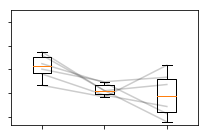

7
Ttest_relResult(statistic=1.8754852496968715, pvalue=0.11956801388472656)
Ttest_relResult(statistic=3.8761916989132, pvalue=0.011686822090407464)
Ttest_relResult(statistic=-3.0032072714782903, pvalue=0.029988552275659993)
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
day  9.0826 2.0000 10.0000 0.0056

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0718 0.3169 -0.1956  0.0521  False
     0      2  -0.2182  0.001  -0.342 -0.0944   True
     1      2  -0.1464   0.02 -0.2703 -0.0226   True
----------------------------------------------------
(array([0.6, 0.8, 1. , 1.2, 1.4]), <a list of 0 Text yticklabel objects>)


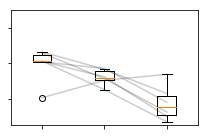

In [52]:
for si in range(8):
    print(si)
    plt.figure(figsize=(3, 2))
    for s in score_full[:, :, si]:
        plt.plot(np.arange(1, 4), s, color="k", alpha=0.2)
    plt.boxplot(score_full[:, :, si])
    for i in range(3):
        print(stats.ttest_rel(score_full[:, i, si], score_full[:, (i+1) % 3, si]))
    df = pd.DataFrame({
        "mouse": np.tile(np.arange(6), 3),
        "day": np.repeat(np.arange(3), 6),
        "error": np.hstack([score_full[:, i, si] for i in range(3)])
    })
    print(AnovaRM(data=df, depvar="error", subject="mouse", within=["day"]).fit())
    tukey = pairwise_tukeyhsd(endog=df['error'],
                                  groups=df['day'],
                                  alpha=0.05)
    print(tukey)
    plt.xticks([1, 2, 3], ["Day 1", "Day 2", "Day6"])
    plt.tick_params(labelleft=False, labelbottom=False)
    y0, y1 = plt.ylim()
    plt.ylim(y0, y1 + (y1 - y0) / 2)
    plt.tight_layout()
    print(plt.yticks())
    plt.savefig("decoder/" + str(si) + "_full.png")
    plt.show()